**IMPORTING LIBRARIES**

In [278]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [279]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report

**CREATING A EMPTY LIST FOR STORING OF PATHS AND LABELS**

In [283]:
paths = []
labels = []

**LABEL STANDARDIZATION**

In [286]:
label_map = {
    'neutral': 'neutral',
    'calm': 'calm',
    'happy': 'happy',
    'sad': 'sad',
    'angry': 'angry',
    'fear': 'fearful',
    'fearful': 'fearful',
    'disgust': 'disgust',
    'ps': 'surprised',
    'pleasant': 'happy',
    'surprise': 'surprised',
    'pleasant_surprise': 'surprised',
    'surprised': 'surprised'
}

**LOADING TESS DATASET**

In [289]:
for dirname, _, filenames in os.walk("C:/Users/SURBHI/Downloads/TESS"):
    for filename in filenames:
        if filename.endswith('.wav'):
            raw_label = filename.split('_')[-1].split('.')[0].lower()
            mapped_label = label_map.get(raw_label)
            if mapped_label:
                paths.append(os.path.join(dirname, filename))
                labels.append(mapped_label)

print(f"TESS dataset loaded: {len(paths)} audio files")
print(f"Labels extracted: {len(labels)}")
print("Unique emotion labels:", set(labels))

TESS dataset loaded: 5600 audio files
Labels extracted: 5600
Unique emotion labels: {'happy', 'fearful', 'neutral', 'angry', 'disgust', 'surprised', 'sad'}


In [290]:
initial_len = len(paths)

**LOADING OF RAVDESS DATASET**

In [294]:
emotion_dict = {
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'}

ravdess_path = "C:/Users/SURBHI/Downloads/RAVDESS"
for dirname, _, filenames in os.walk(ravdess_path):
    for filename in filenames:
        if filename.endswith(".wav"):
            emotion_code = int(filename.split('-')[2])
            raw_label = emotion_dict.get(emotion_code)
            if raw_label:
                paths.append(os.path.join(dirname, filename))
                labels.append(raw_label)

new_files = len(paths) - initial_len
if new_files > 0:
    print(f" RAVDESS dataset loaded: {new_files} audio files added")
    print(f" Total audio files: {len(paths)}")
    print(f" Labels extracted: {len(labels)}")
    print("Unique emotion labels:", set(labels))
else:
    print("No new audio files loaded from RAVDESS")

 RAVDESS dataset loaded: 2880 audio files added
 Total audio files: 8480
 Labels extracted: 8480
Unique emotion labels: {'calm', 'happy', 'fearful', 'neutral', 'angry', 'disgust', 'surprised', 'sad'}


**DATA PREPROCESSING**

In [297]:
print("Length of paths:", len(paths))
print("Length of labels:", len(labels))

Length of paths: 8480
Length of labels: 8480


In [299]:
#LOADING OF NORMALIZED LABELS:

df = pd.DataFrame({'speech': paths, 'label': labels})
print(" Loaded and normalized labels:", df['label'].unique())

 Loaded and normalized labels: ['angry' 'disgust' 'fearful' 'happy' 'neutral' 'surprised' 'sad' 'calm']


In [301]:
#DROPPING NAN VALUES FROM COULMNS SPEECH AND LABEL:

print("Before cleaning:", df.shape)
df.dropna(subset=['speech', 'label'], inplace=True)
df = df[(df['speech'].str.strip() != '') & (df['label'].str.strip() != '')]
print("After cleaning:", df.shape)
print("NaN in 'speech':", df['speech'].isna().sum())
print("NaN in 'label':", df['label'].isna().sum())
print("Empty speech rows:", (df['speech'].str.strip() == '').sum())
print("Empty label rows:", (df['label'].str.strip() == '').sum())

Before cleaning: (8480, 2)
After cleaning: (8480, 2)
NaN in 'speech': 0
NaN in 'label': 0
Empty speech rows: 0
Empty label rows: 0


In [303]:
print("Before file existence check:", df.shape)
df = df[df['speech'].apply(lambda path: os.path.exists(path))]
print("After file existence check:", df.shape)

Before file existence check: (8480, 2)
After file existence check: (8480, 2)


In [304]:
len(paths)

8480

In [305]:
df.head()

,speech,label
0,C:/Users/SURBHI/Downloads/TESS\TESS Toronto em...,angry
1,C:/Users/SURBHI/Downloads/TESS\TESS Toronto em...,angry
2,C:/Users/SURBHI/Downloads/TESS\TESS Toronto em...,angry
3,C:/Users/SURBHI/Downloads/TESS\TESS Toronto em...,angry
4,C:/Users/SURBHI/Downloads/TESS\TESS Toronto em...,angry


In [306]:
paths[:5]

['C:/Users/SURBHI/Downloads/TESS\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav',
 'C:/Users/SURBHI/Downloads/TESS\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav',
 'C:/Users/SURBHI/Downloads/TESS\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav',
 'C:/Users/SURBHI/Downloads/TESS\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav',
 'C:/Users/SURBHI/Downloads/TESS\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']

In [309]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

**WAVEPLOT VISUALIZATION FOR EMOTION:**

In [314]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

**SPECTOGRAM VISUALIZATION FOR EMOTION**

In [317]:
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

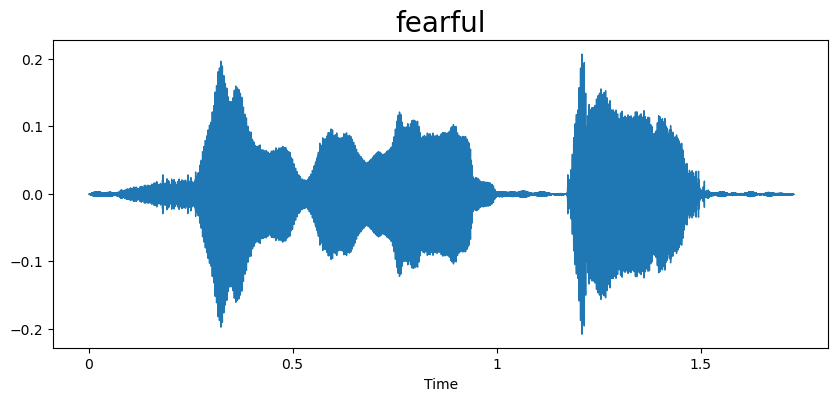

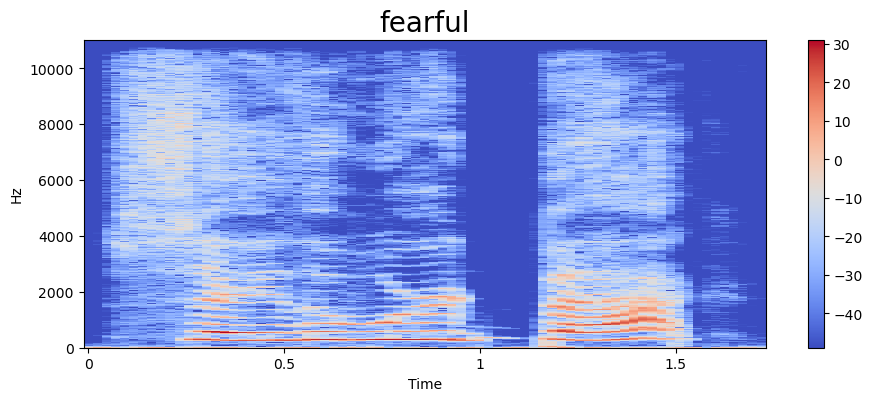

In [318]:
emotion = 'fearful'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

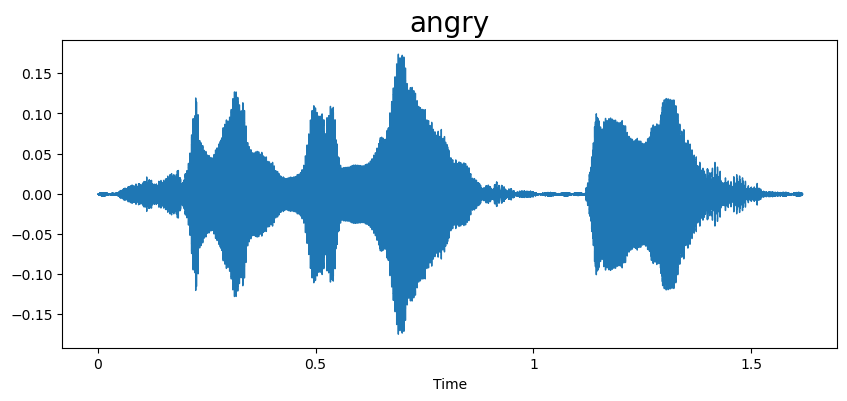

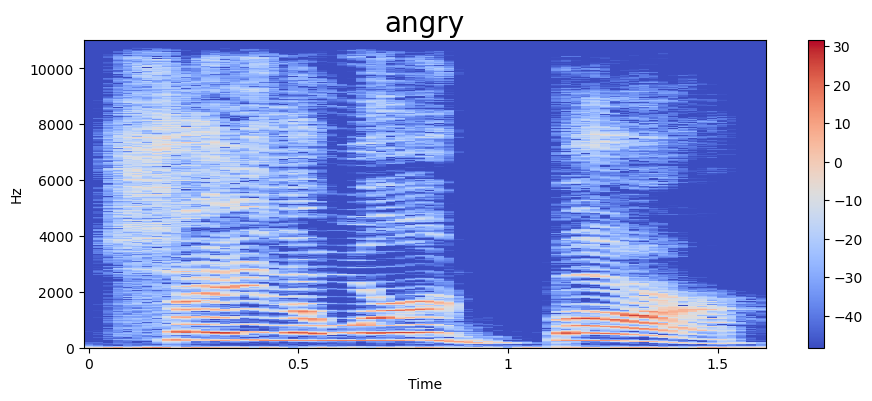

In [320]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

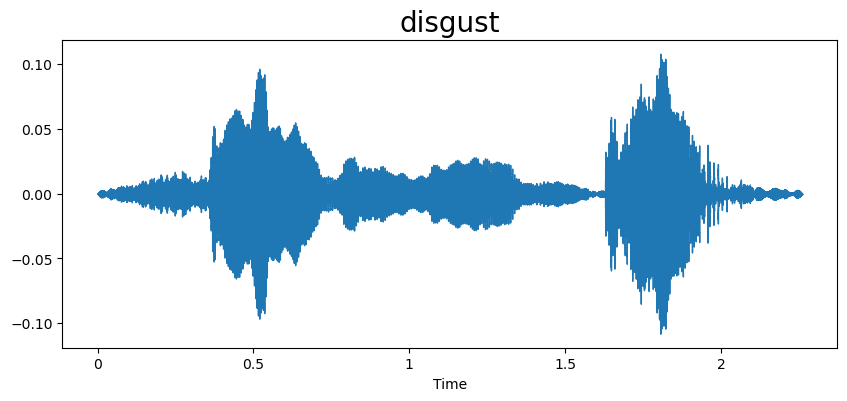

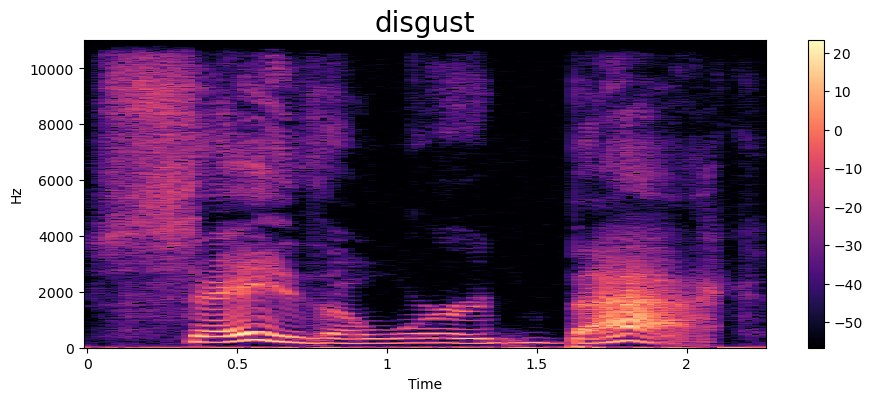

In [321]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

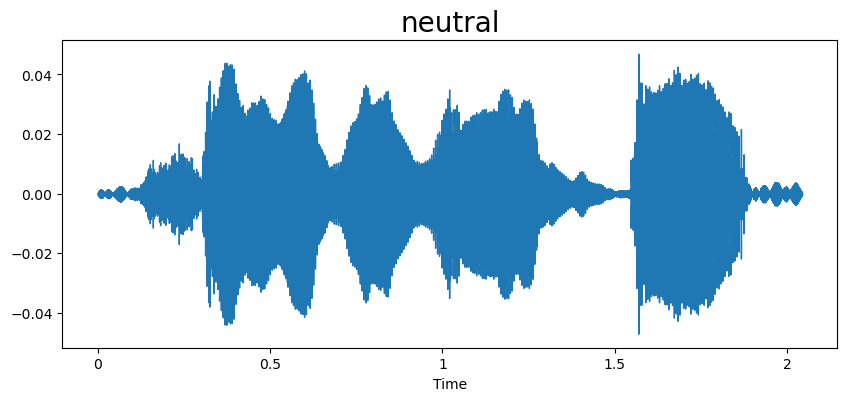

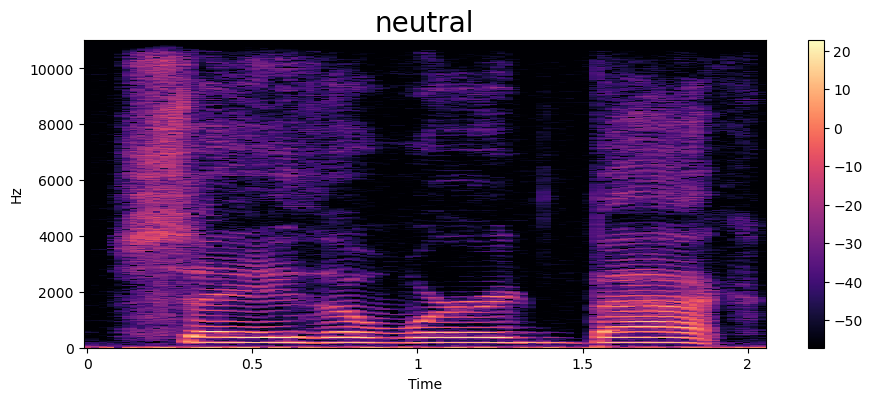

In [322]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

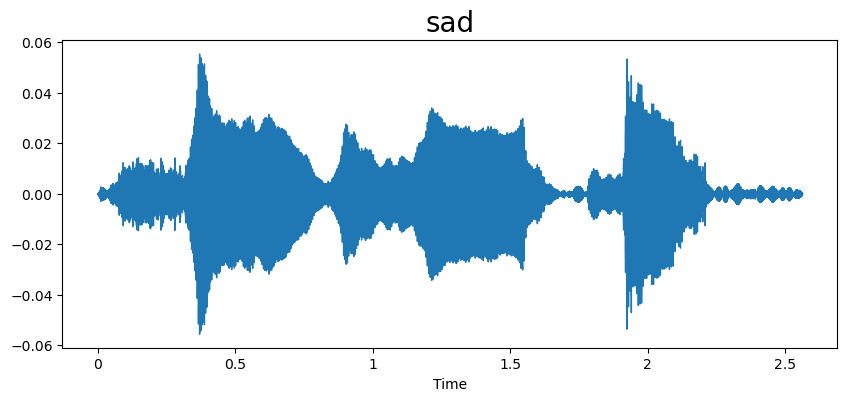

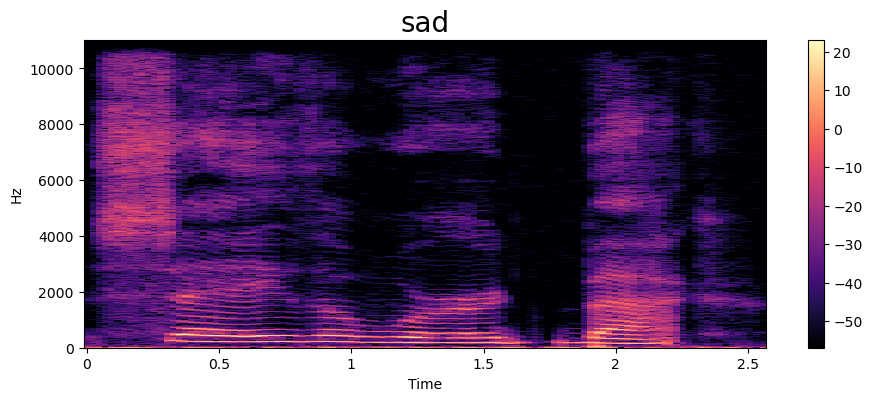

In [323]:
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

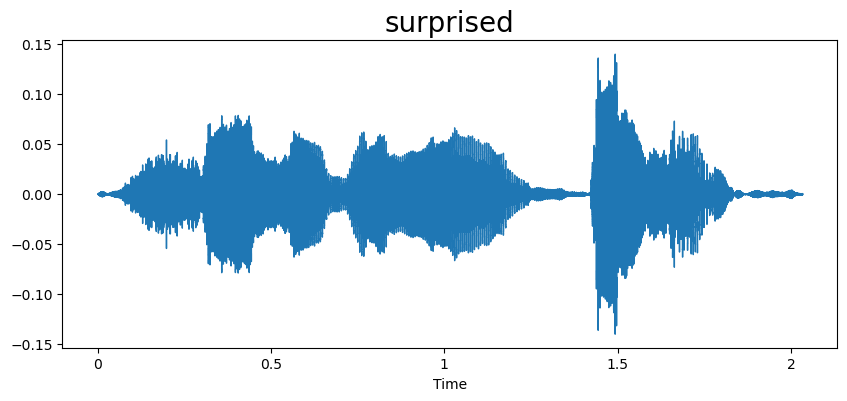

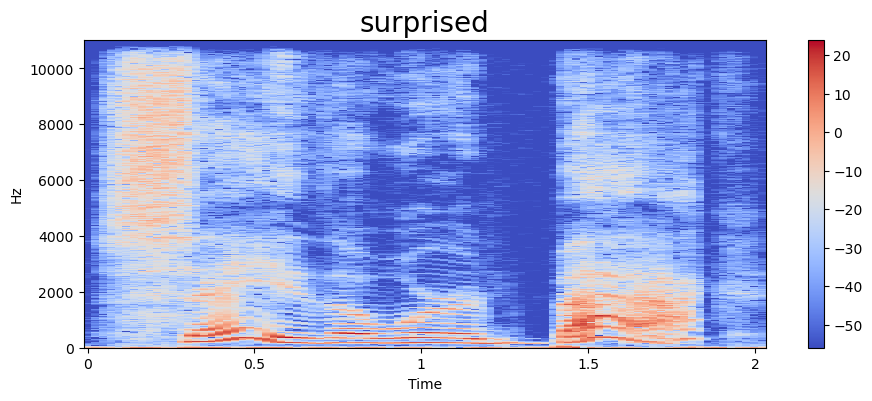

In [324]:
emotion = 'surprised'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

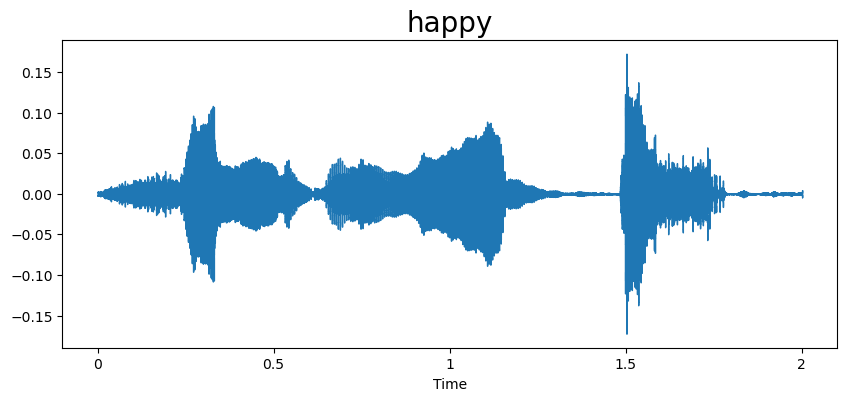

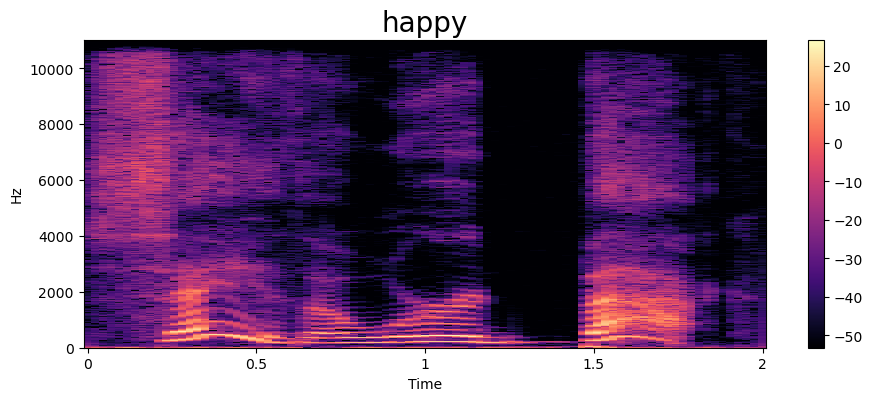

In [326]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

<Axes: title={'center': 'Balanced Class Distribution'}, xlabel='label'>

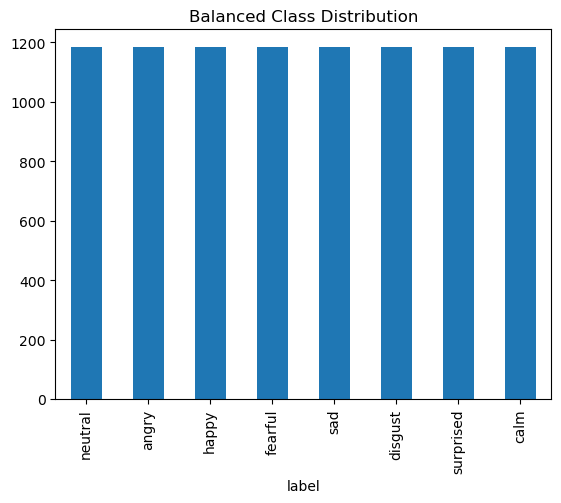

In [329]:
#BALANCE THE DATASET:
max_samples = df['label'].value_counts().max()
balanced_df = pd.DataFrame()

for emotion in df['label'].unique():
    subset = df[df['label'] == emotion]
    upsampled = resample(subset, replace=True, n_samples=max_samples, random_state=42)
    balanced_df = pd.concat([balanced_df, upsampled])

balanced_df = balanced_df.sample(frac=1).dropna().reset_index(drop=True)
balanced_df['label'].value_counts().plot(kind='bar', title='Balanced Class Distribution')


**MFCC FEATURE EXTRACTION:**

In [336]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    try:
        y, sr = librosa.load(file_path, sr=None)
    except Exception as e:
        print(f" Failed to load {file_path}: {e}")
        return None
        
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    
    # Chroma
    stft = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    chroma_mean = np.mean(chroma.T, axis=0)
    
    # RMS Energy
    rms = librosa.feature.rms(y=y)
    rms_mean = np.mean(rms.T, axis=0)
    
    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr.T, axis=0)

    # Combine all features
    combined_features = np.hstack([mfccs_mean, chroma_mean, rms_mean, zcr_mean])
    print(f"{file_path} → Combined {len(combined_features)} features")
    return combined_features

In [338]:
X = []
y_clean = []

for path, label in zip(paths, labels):
    features = extract_features(path)
    if features is not None:
        X.append(features)
        y_clean.append(label)

X = np.array(X)
y = np.array(y_clean)
print(f" Extracted features for {len(X)} samples")


C:/Users/SURBHI/Downloads/TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_back_angry.wav → Combined 54 features
C:/Users/SURBHI/Downloads/TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_bar_angry.wav → Combined 54 features
C:/Users/SURBHI/Downloads/TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_base_angry.wav → Combined 54 features
C:/Users/SURBHI/Downloads/TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_bath_angry.wav → Combined 54 features
C:/Users/SURBHI/Downloads/TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_bean_angry.wav → Combined 54 features
C:/Users/SURBHI/Downloads/TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_beg_angry.wav → Combined 54 features
C:/Users/SURBHI/Downloads/TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_bite_angry.wav → Combined 54 features
C:/Users/SURBHI/Downloads/TESS\TESS Toronto emotional speech set data\OAF_angry\OAF_boat_angry.wav → Combined 54 features
C:/Users/SURBHI/Downloads/

In [342]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_encoded, random_state=42)
print("Train/Test split done.")

Train/Test split done.


In [346]:
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

**MODEL BUILDING, COMPILATION AND TRAINING**

In [349]:
#CREATING A DENSE NEURAL NETWORK:
model = Sequential([
    Dense(256, activation='relu', input_shape=(54,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

#MODEL COMPILATION:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#FITTING ON TEST AND TRAINING DATA:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=80, batch_size=32)

Epoch 1/80
212/212 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.1651 - loss: 15.1627 - val_accuracy: 0.1893 - val_loss: 2.0214
Epoch 2/80
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2309 - loss: 1.9979 - val_accuracy: 0.4021 - val_loss: 1.6570
Epoch 3/80
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3277 - loss: 1.7642 - val_accuracy: 0.5118 - val_loss: 1.4398
Epoch 4/80
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4111 - loss: 1.5088 - val_accuracy: 0.5755 - val_loss: 1.2073
Epoch 5/80
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4668 - loss: 1.3502 - val_accuracy: 0.6191 - val_loss: 1.0845
Epoch 6/80
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5105 - loss: 1.2277 - val_accuracy: 0.6403 - val_loss: 0.9830
Epoch 7/80
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5523 - loss: 1.1347 - val_accuracy: 0.6763 - val_loss: 0.8957
Epoch 8/80
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6065 - loss: 1.0169 - val_accuracy: 0

In [353]:
#PREDICTION ON TEST DATA:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


**CONFUSION MATRIX**

In [356]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
encoder = LabelEncoder()
y = encoder.fit_transform(df['label'])
labels = encoder.classes_

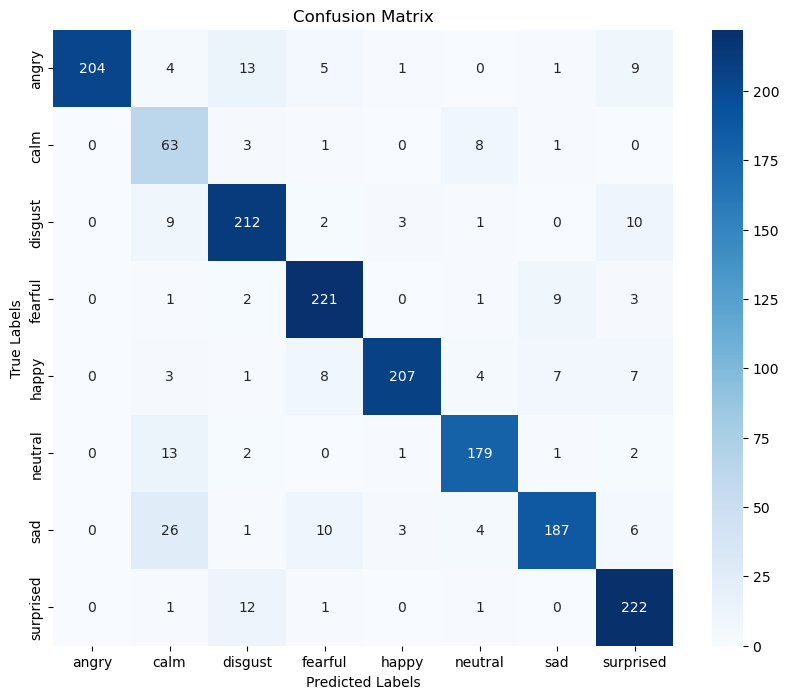

In [358]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [360]:
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

              precision    recall  f1-score   support

       angry       1.00      0.86      0.93       237
        calm       0.53      0.83      0.64        76
     disgust       0.86      0.89      0.88       237
     fearful       0.89      0.93      0.91       237
       happy       0.96      0.87      0.92       237
     neutral       0.90      0.90      0.90       198
         sad       0.91      0.79      0.84       237
   surprised       0.86      0.94      0.90       237

    accuracy                           0.88      1696
   macro avg       0.86      0.88      0.86      1696
weighted avg       0.89      0.88      0.88      1696



In [362]:
epochs = list(range(len(history.history['accuracy'])))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

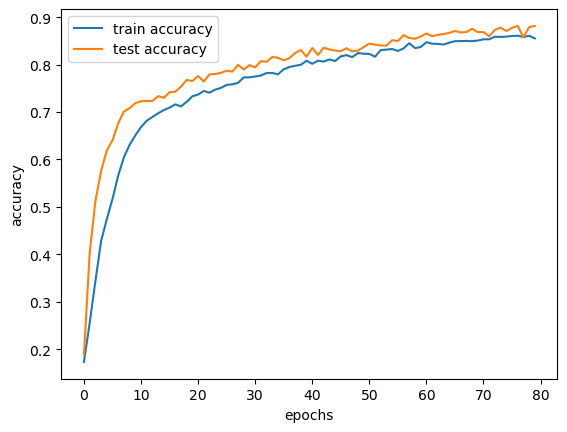

In [364]:
plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='test accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [366]:
loss = history.history['loss']
val_loss = history.history['val_loss']

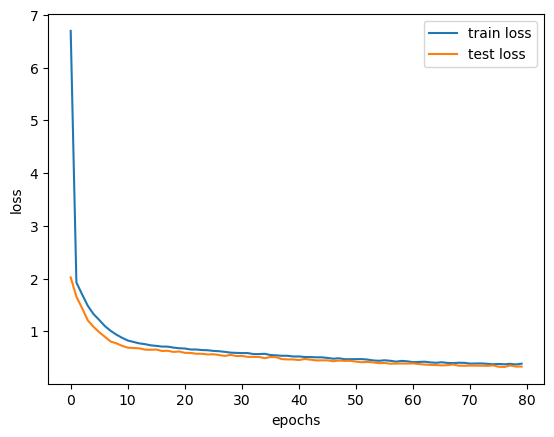

In [368]:
plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show() 

In [379]:
model.save("final_improved_model.h5")
print(" Model saved as 'final_improved_model.h5'")

 Model saved as 'final_improved_model.h5'
